# **COVID 19 PPE Object Detection Using EffcientNet**

   <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

## <div style="background-color:#B21010;font-family:sans-serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:9px 9px; padding: 15px; border-style: solid; border-color: black">TABLE OF CONTENTS</div>   
    
* [1. Introduction](#1)
    
* [2. Import Necessaries](#2)
    
* [3. EDA + Visulaization](#3)
    
* [4. Define model name and url](#4)
    
* [5. SetUp paths](#5)

* [6. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD](#6)

* [7. Copy Model Config to Training Folder](#7)

* [8. Update Config For Transfer Learning](#8)

* [9. Train the model](#9)

* [10. Evaluate the model](#10)


 


<a id="1"></a>
## <b>1 <span style='color:#B21010'>||</span> Introduction</b>

COVID-19 Personal Protective Equipment (PPE) Detection Dataset for Our COVID-19 Warriors
We wanted to do something for our COVID Warriors and hence decided to detect the PPE kit(Mask, Face Sheild, Full Cover, Gloves, Goggles) which they wear before entering a Ward using Machine Learning so that anyone without a PPE can be detected and doesn't incidentally get into a COVID ward.

<a id="2"></a>
## <b>2 <span style='color:#B21010'>||</span> Import Necessaries</b>

In [65]:
!pip install wget


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=18c9306d94ffd62670928ffcfb4841e81071f81cd4a9121c5c289ca82d67c267
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [66]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import missingno as msno
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from PIL import Image, ImageDraw
import os
import cv2
import wget

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id="3"></a>
## <b>3 <span style='color:#B21010'>||</span> EDA + Visulization</b>

#### **Define Train and test image paths**

In [10]:
train_path = '/content/drive/MyDrive/Tensorflow/train_labels.csv'
test_path = '/content/drive/MyDrive/Tensorflow/test_labels.csv'

#### **Read Train and test csv files for EDA**

In [11]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [12]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,snap07301.jpg,1920,1088,Gloves,769,568,835,680
1,snap07301.jpg,1920,1088,Gloves,988,557,1043,681
2,snap07301.jpg,1920,1088,Mask,870,151,929,226
3,snap07301.jpg,1920,1088,Face_Shield,842,105,951,244
4,snap07301.jpg,1920,1088,Coverall,748,58,1060,954


In [13]:
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,sdh.jpg,1600,1000,Goggles,734,59,1200,336
1,sdh.jpg,1600,1000,Mask,779,224,1147,496
2,sdh.jpg,1600,1000,Gloves,538,628,735,862
3,sdh.jpg,1600,1000,Gloves,868,744,1265,900
4,sdh.jpg,1600,1000,Coverall,292,1,1406,898


#### **Print Shape of each dataframe**

In [14]:
def shape_of_dataset(df, dataset_name="df"):
    
    print(f"{dataset_name} dataset has {df.shape[0]} nrows and {df.shape[1]} ncolumns")
    return df.shape[0], df.shape[1]

In [15]:
train_r, train_c = shape_of_dataset(train_df, "Train")
test_r, test_c = shape_of_dataset(test_df, "Test")

Train dataset has 1614 nrows and 8 ncolumns
Test dataset has 362 nrows and 8 ncolumns


#### **Display info of the dataframes**

In [16]:
def dataset_info(df, ds_name='df'):
  print(f"info about {ds_name} dataset\n\n")
  print(df.info())

In [17]:
dataset_info(train_df, 'train')
print('\n')
dataset_info(test_df, 'test')

info about train dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1614 entries, 0 to 1613
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1614 non-null   object
 1   width     1614 non-null   int64 
 2   height    1614 non-null   int64 
 3   class     1614 non-null   object
 4   xmin      1614 non-null   int64 
 5   ymin      1614 non-null   int64 
 6   xmax      1614 non-null   int64 
 7   ymax      1614 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 101.0+ KB
None


info about test dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  362 non-null    object
 1   width     362 non-null    int64 
 2   height    362 non-null    int64 
 3   class     362 non-null    object
 4   xmin      362 non-null    int64 
 5   ymin      362 non-null    i

#### **Display and plot the distrbution of null values**

In [18]:
def detect_null(df, ds_name='df'):
  print(f"Number of null values in each col in the {ds_name} dataset \n\n{df.isnull().sum()}")

In [20]:
detect_null(train_df, 'train')
print('\n')
detect_null(test_df, 'test')

Number of null values in each col in the train dataset 

filename    0
width       0
height      0
class       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64


Number of null values in each col in the test dataset 

filename    0
width       0
height      0
class       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64


Text(0.5, 1.0, 'Distribution of Missing Values in the testing dataset')

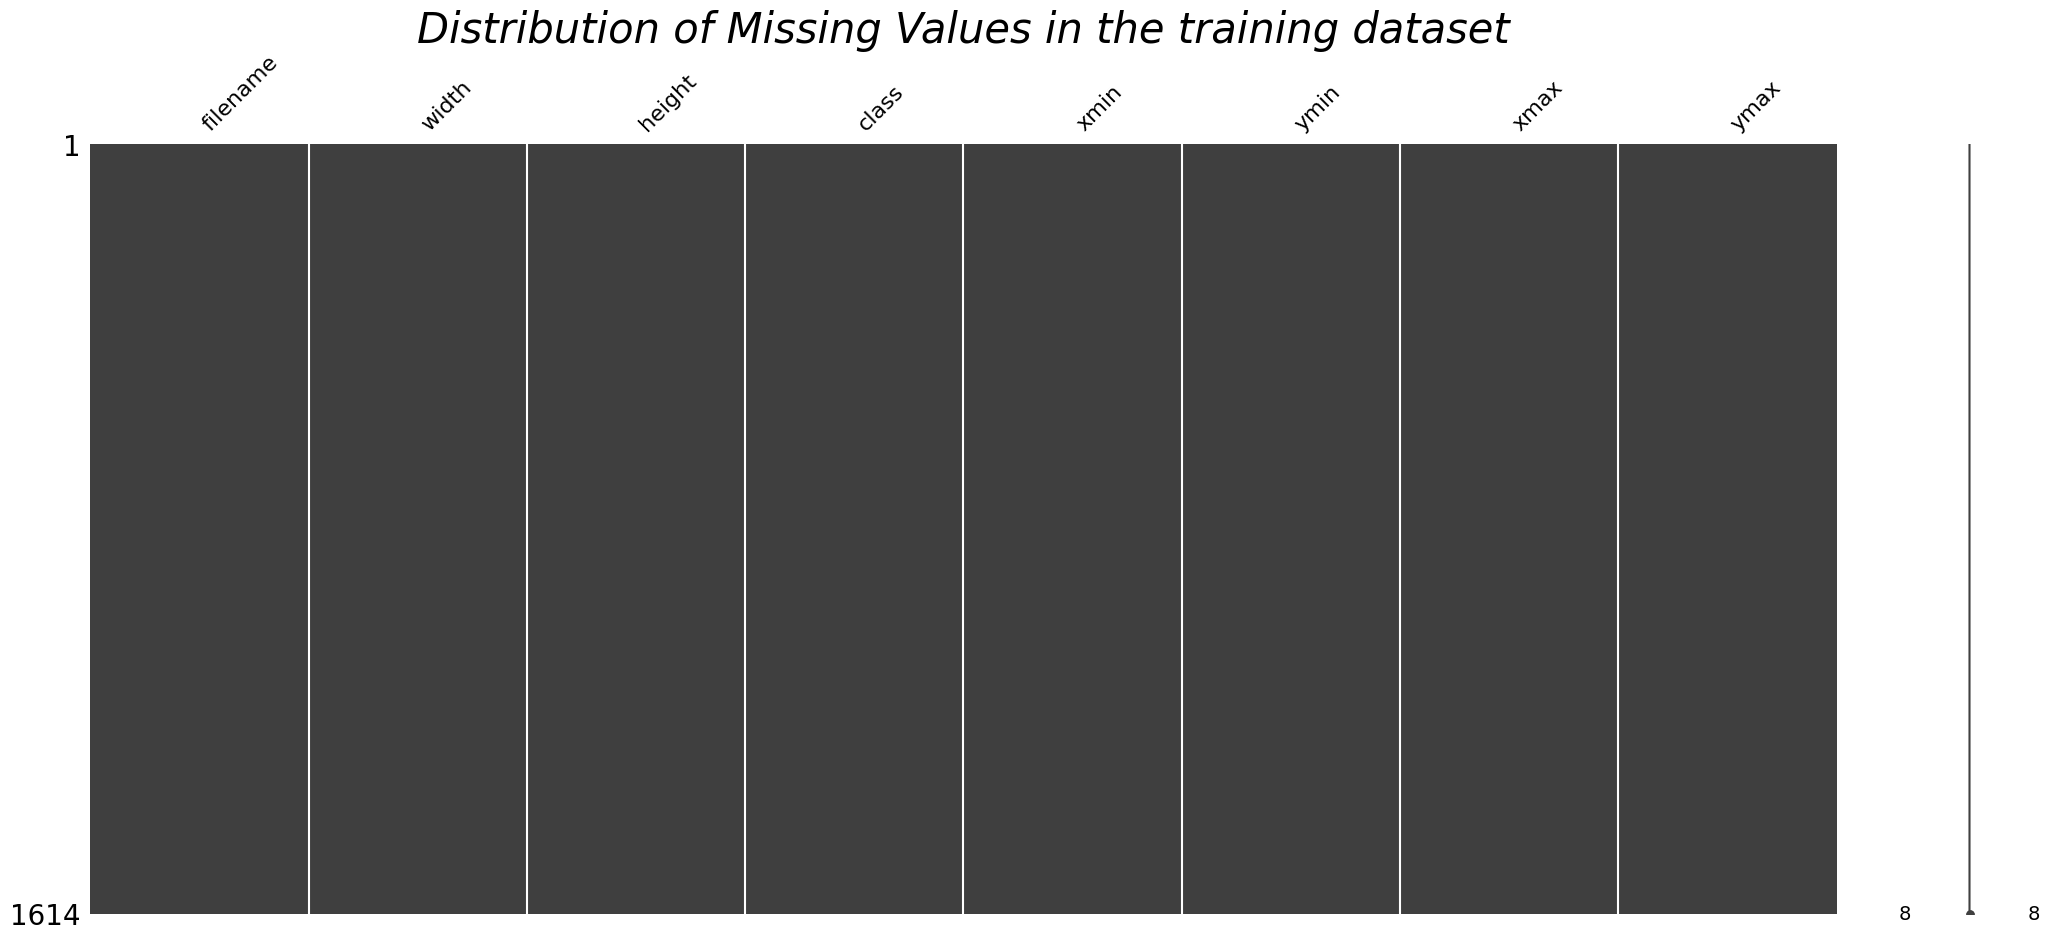

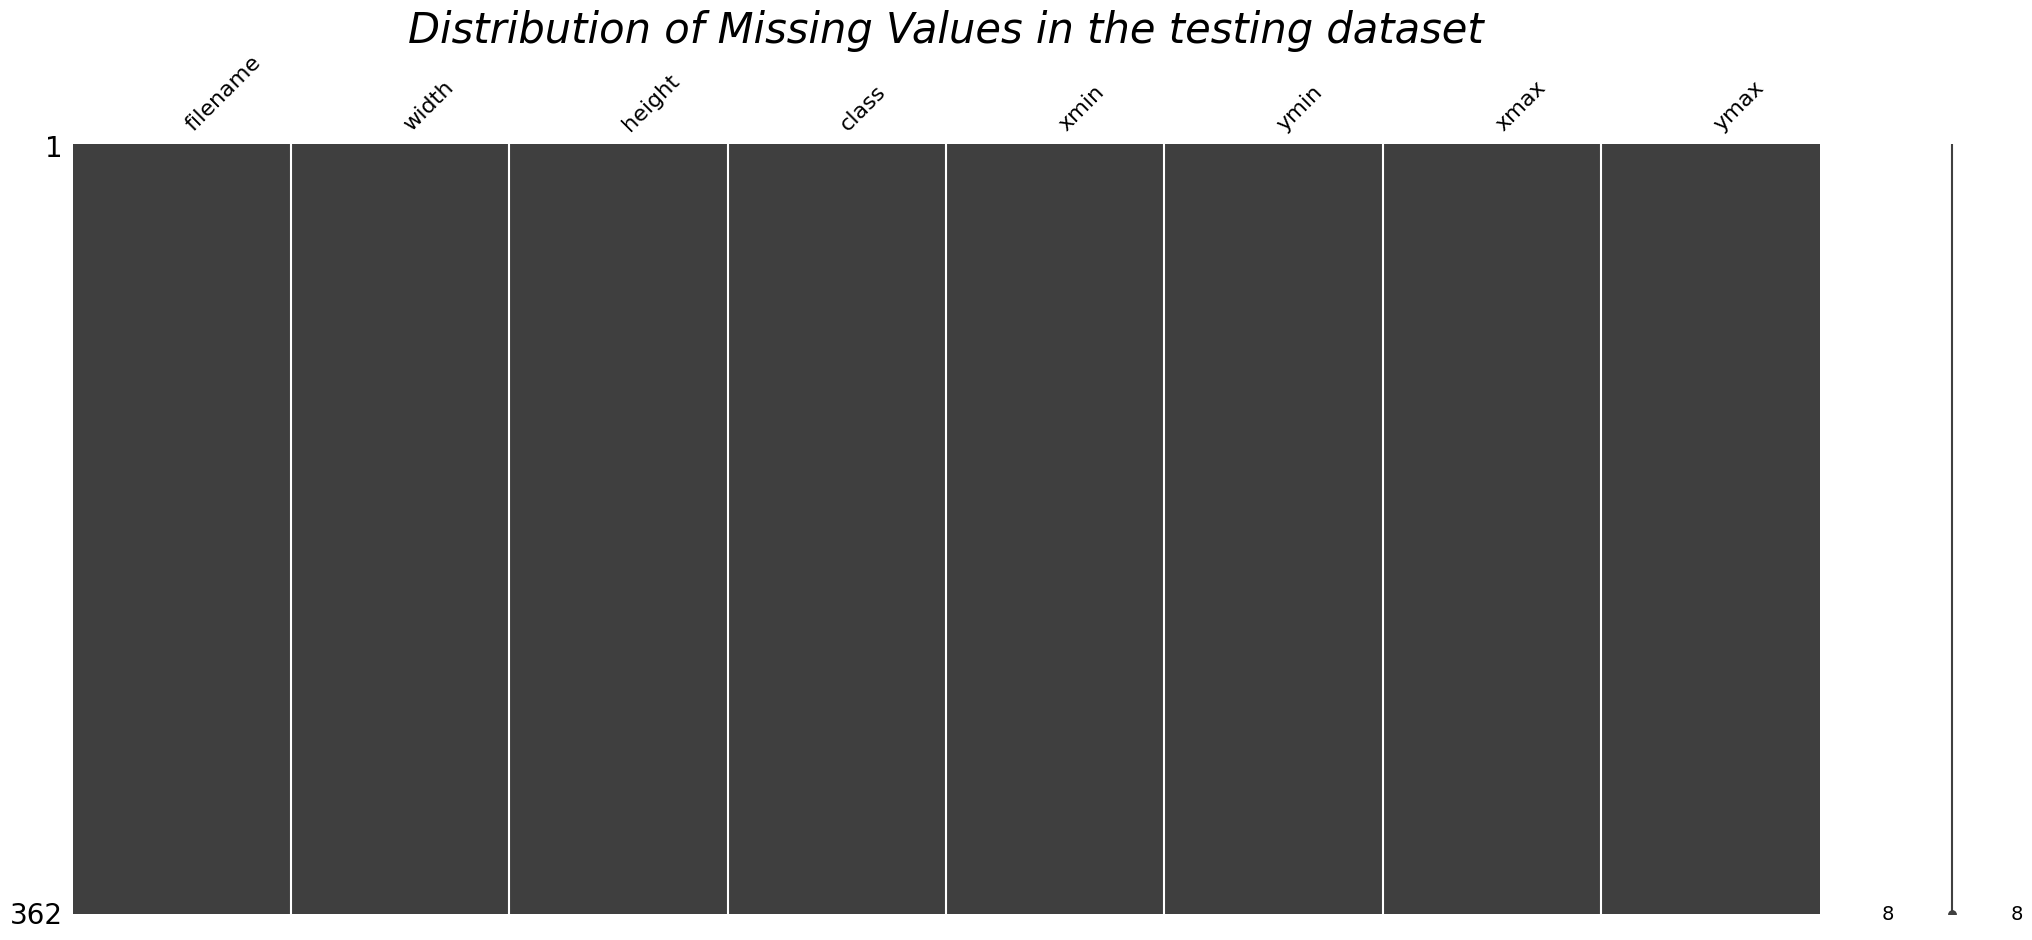

In [29]:
msno.matrix(train_df)
plt.title(f'Distribution of Missing Values in the training dataset', fontsize=30, fontstyle='oblique')
msno.matrix(test_df)
plt.title(f'Distribution of Missing Values in the testing dataset', fontsize=30, fontstyle='oblique')

#### **Display number of unique values of cols in each dataframe**

In [23]:
def display_unique_val(df, ds_name='df'):
  print(f"Number of unique values in each col in the {ds_name} dataset \n\n{df.nunique()}")

In [24]:
display_unique_val(train_df, 'train')
print('\n')
display_unique_val(test_df, 'test')

Number of unique values in each col in the train dataset 

filename    367
width        54
height       74
class         5
xmin        830
ymin        562
xmax        920
ymax        655
dtype: int64


Number of unique values in each col in the test dataset 

filename     50
width        35
height       42
class         5
xmin        296
ymin        250
xmax        294
ymax        282
dtype: int64


#### **Display datatypes of the cols in the dfs**

In [25]:
def display_dtypes(df, ds_name='df'):
  print(f"Data types of cols in the {ds_name} dataset\n\n{df.dtypes}")

In [26]:
display_dtypes(train_df, 'train')
print('\n')
display_dtypes(test_df, 'test')

Data types of cols in the train dataset

filename    object
width        int64
height       int64
class       object
xmin         int64
ymin         int64
xmax         int64
ymax         int64
dtype: object


Data types of cols in the test dataset

filename    object
width        int64
height       int64
class       object
xmin         int64
ymin         int64
xmax         int64
ymax         int64
dtype: object


#### **Plot the distrbution of the labels in the datasets**

In [27]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)

colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

In [28]:
cat_summary_with_graph(train_df, 'class')
cat_summary_with_graph(test_df, 'class')

#### **Descriptive Statistics**

In [30]:
train_df.describe().T.style.set_properties(**{"background-color": "red", "font-size" : "17px",
                                        "color": "#ffffff", "border-radius" : "1px", "border": "1.5px solid black"})

,count,mean,std,min,25%,50%,75%,max
width,1614.000000,1343.381041,533.844304,0.000000,900.000000,1280.000000,1920.000000,3600.000000
height,1614.000000,803.259603,308.043024,0.000000,576.000000,720.000000,1088.000000,2340.000000
xmin,1614.000000,562.322181,318.520416,1.000000,304.250000,559.000000,805.000000,2241.000000
ymin,1614.000000,258.218092,193.540260,1.000000,111.000000,217.500000,362.750000,1268.000000
xmax,1614.000000,805.774473,398.254985,53.000000,482.500000,805.500000,1101.000000,3594.000000
ymax,1614.000000,506.516109,291.849800,48.000000,275.000000,455.000000,694.000000,2070.000000


In [32]:
test_df.describe().T.style.set_properties(**{"background-color": "green", "font-size" : "17px",
                                        "color": "#ffffff", "border-radius" : "1px", "border": "1.5px solid black"})

,count,mean,std,min,25%,50%,75%,max
width,362.000000,1188.408840,837.634292,296.000000,716.000000,900.000000,1200.000000,4552.000000
height,362.000000,799.359116,575.924148,247.000000,450.000000,563.500000,834.000000,2832.000000
xmin,362.000000,498.646409,521.578551,1.000000,212.000000,369.500000,612.250000,3601.000000
ymin,362.000000,233.803867,218.217477,1.000000,82.250000,162.000000,333.000000,1404.000000
xmax,362.000000,718.613260,658.532802,10.000000,345.250000,535.000000,797.500000,4538.000000
ymax,362.000000,491.696133,432.481965,54.000000,216.000000,397.500000,593.500000,2827.000000


#### **Display Number of images in the dataset**

In [33]:
print(f"We have {train_df['filename'].nunique()} training images")
print(f"We have {test_df['filename'].nunique()} testing images")

We have 367 training images
We have 50 testing images


In [38]:
len(train_df['filename'].unique())

367

In [40]:
train_df[train_df['filename'] == train_df['filename'][0]]['width'].values[0]

1920

#### **PLot the distrbution of the image resolution**

In [53]:
def plot_img_res(df, ds_name='df'):
    df_img = len(train_df['filename'].unique())
    ps=np.zeros(df_img)
    for i in range(df_img):
        width = df[df['filename'] == df['filename'][i]]['width'].values[0]
        height = df[df['filename'] == df['filename'][i]]['height'].values[0]
        ps[i]= (width * height) /1e6
    sns.histplot(x=ps)
    plt.xlabel('Image in MB')
    plt.title(f'Image Resolution in {ds_name} dataset')

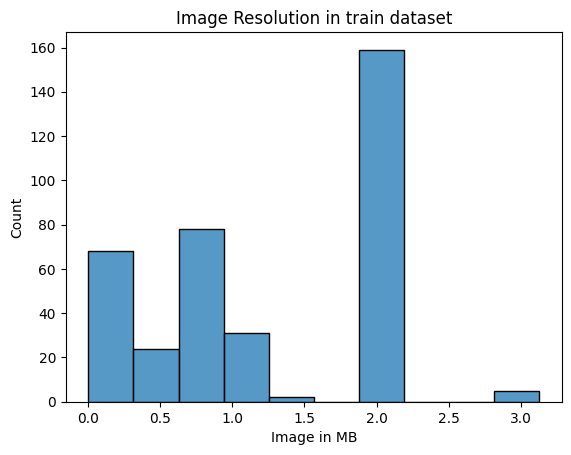

In [54]:
plot_img_res(train_df, 'train')

#### **Plot the distrbution of width and height of the images**

<Figure size 2000x1500 with 0 Axes>

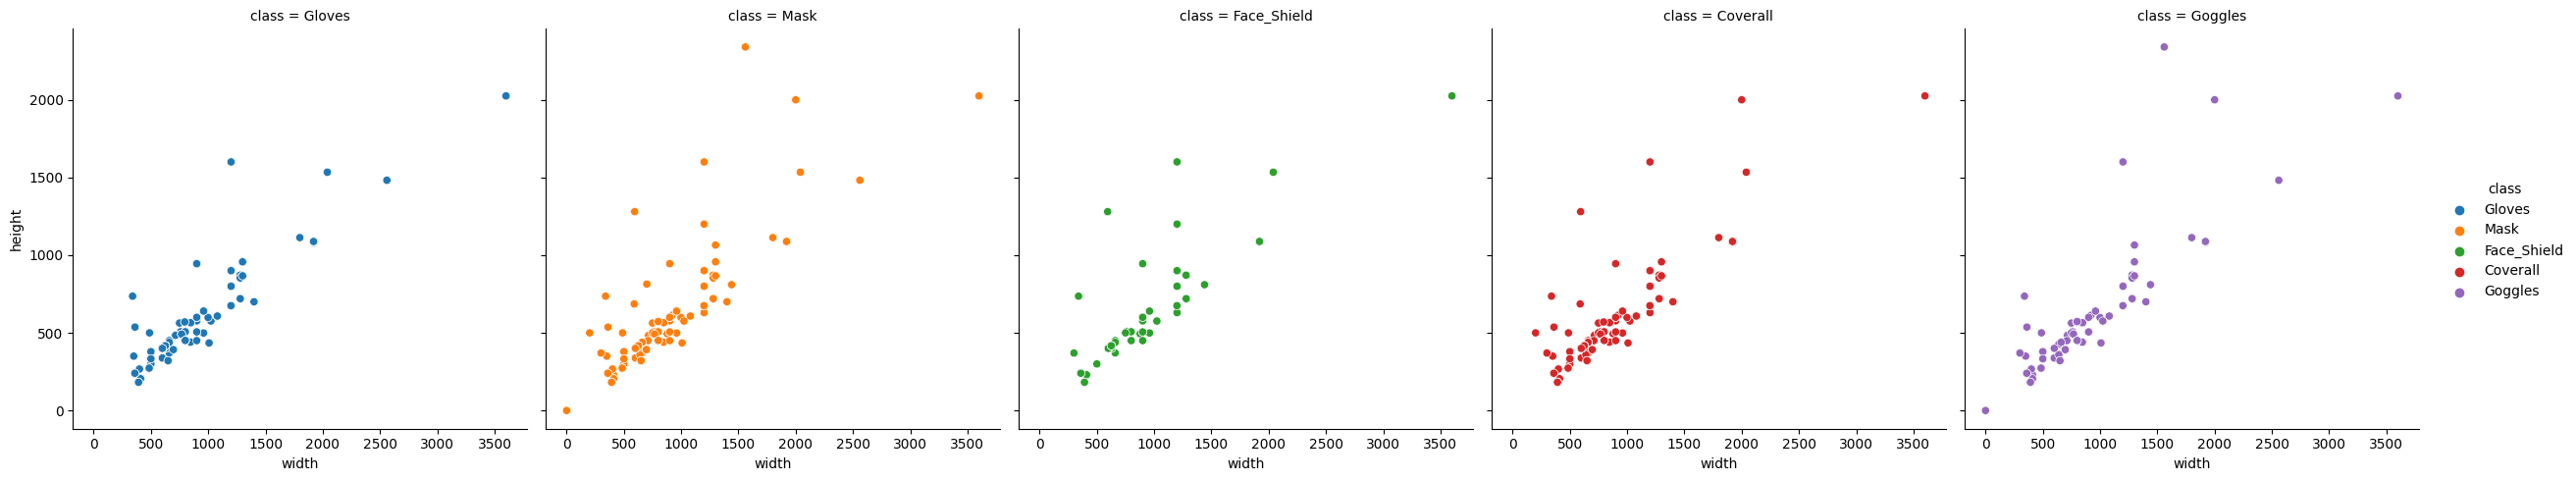

In [56]:
plt.figure(figsize=(20,15))
sns.relplot(x="width", y="height", hue="class", col="class", data=train_df);

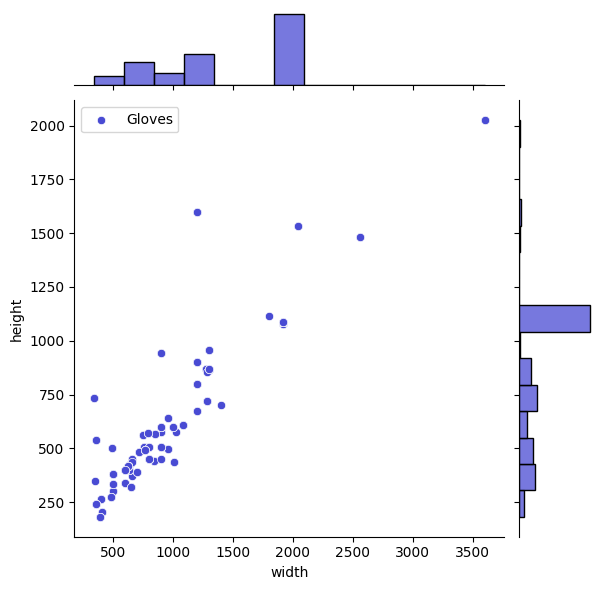

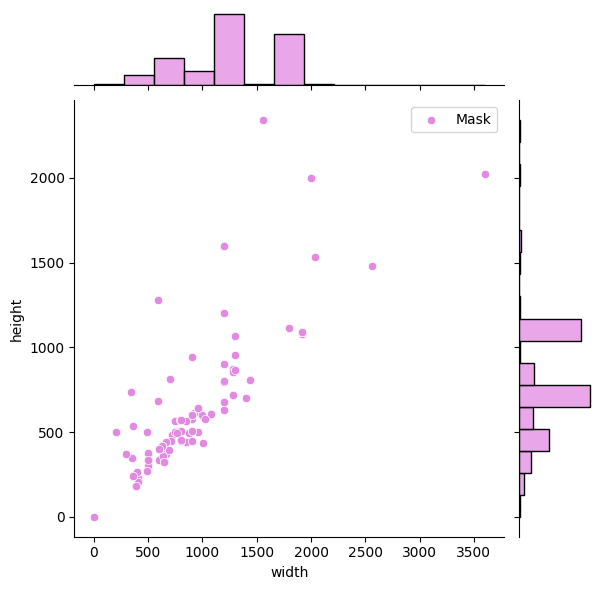

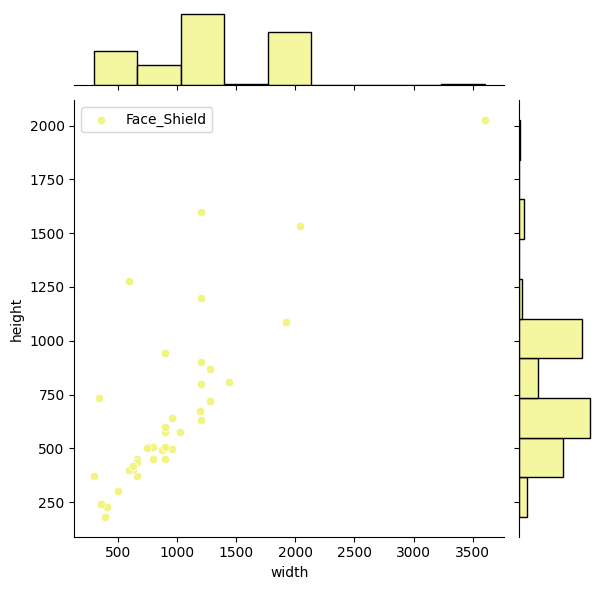

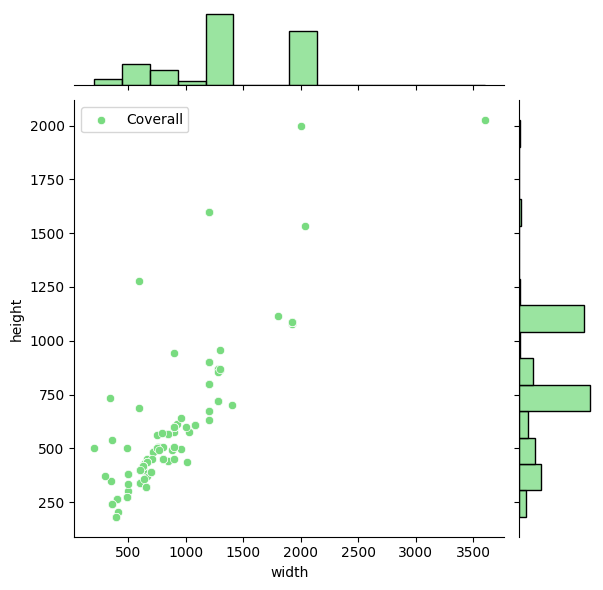

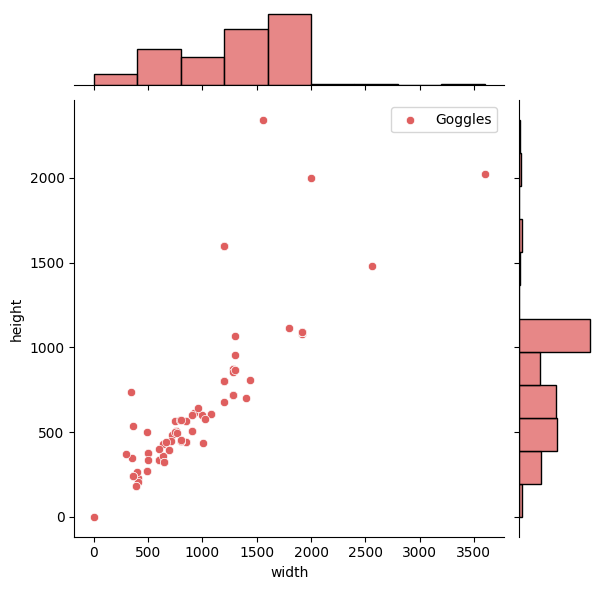

In [57]:
color = 0
for label in train_df['class'].unique():
    sns.jointplot(x="width", y="height", data=train_df.loc[train_df['class'] == label], color=colors[color])
    plt.legend(labels=[label])
    color+=1

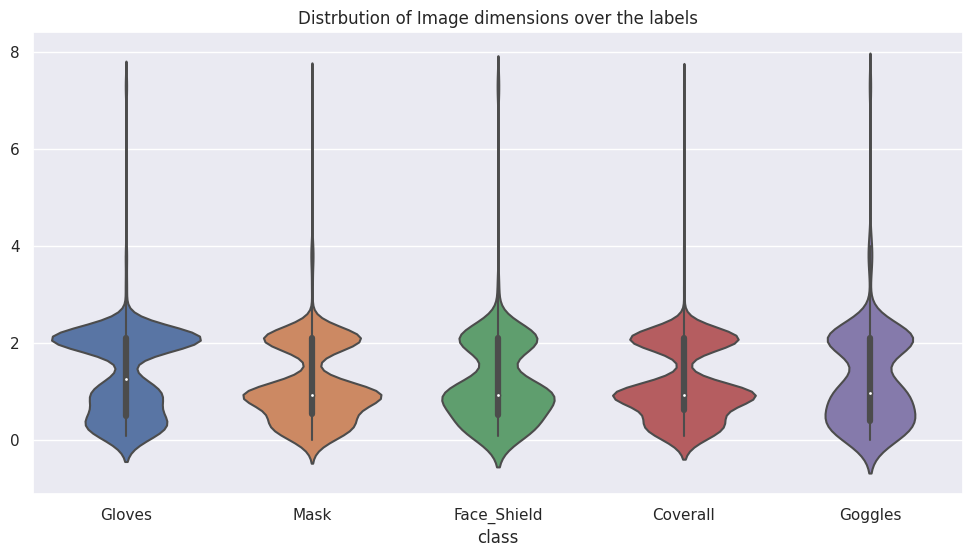

In [60]:
sns.set(rc={'figure.figsize':(12,6)})
sns.violinplot(x=train_df['class'],y=(train_df['width']*train_df['height'])/1e6)
plt.title('Distrbution of Image dimensions over the labels');

#### **Get the aspect ratio**

In [61]:
def get_images_avg_width_height(df, ds_name = 'df'):
    
    wid = df['width'].sum()
    hei = df['height'].sum()
    
    avg_wid = wid // len(df)
    avg_hei = hei // len(df)
    
    print(f"Average width and height for the {ds_name} dataset is {avg_wid}x{avg_hei} with aspect_ratio {avg_wid/avg_hei}")

In [62]:
get_images_avg_width_height(train_df, "train")
get_images_avg_width_height(test_df, "test")

Average width and height for the train dataset is 1343x803 with aspect_ratio 1.672478206724782
Average width and height for the test dataset is 1188x799 with aspect_ratio 1.4868585732165207


#### **PLot sample images**

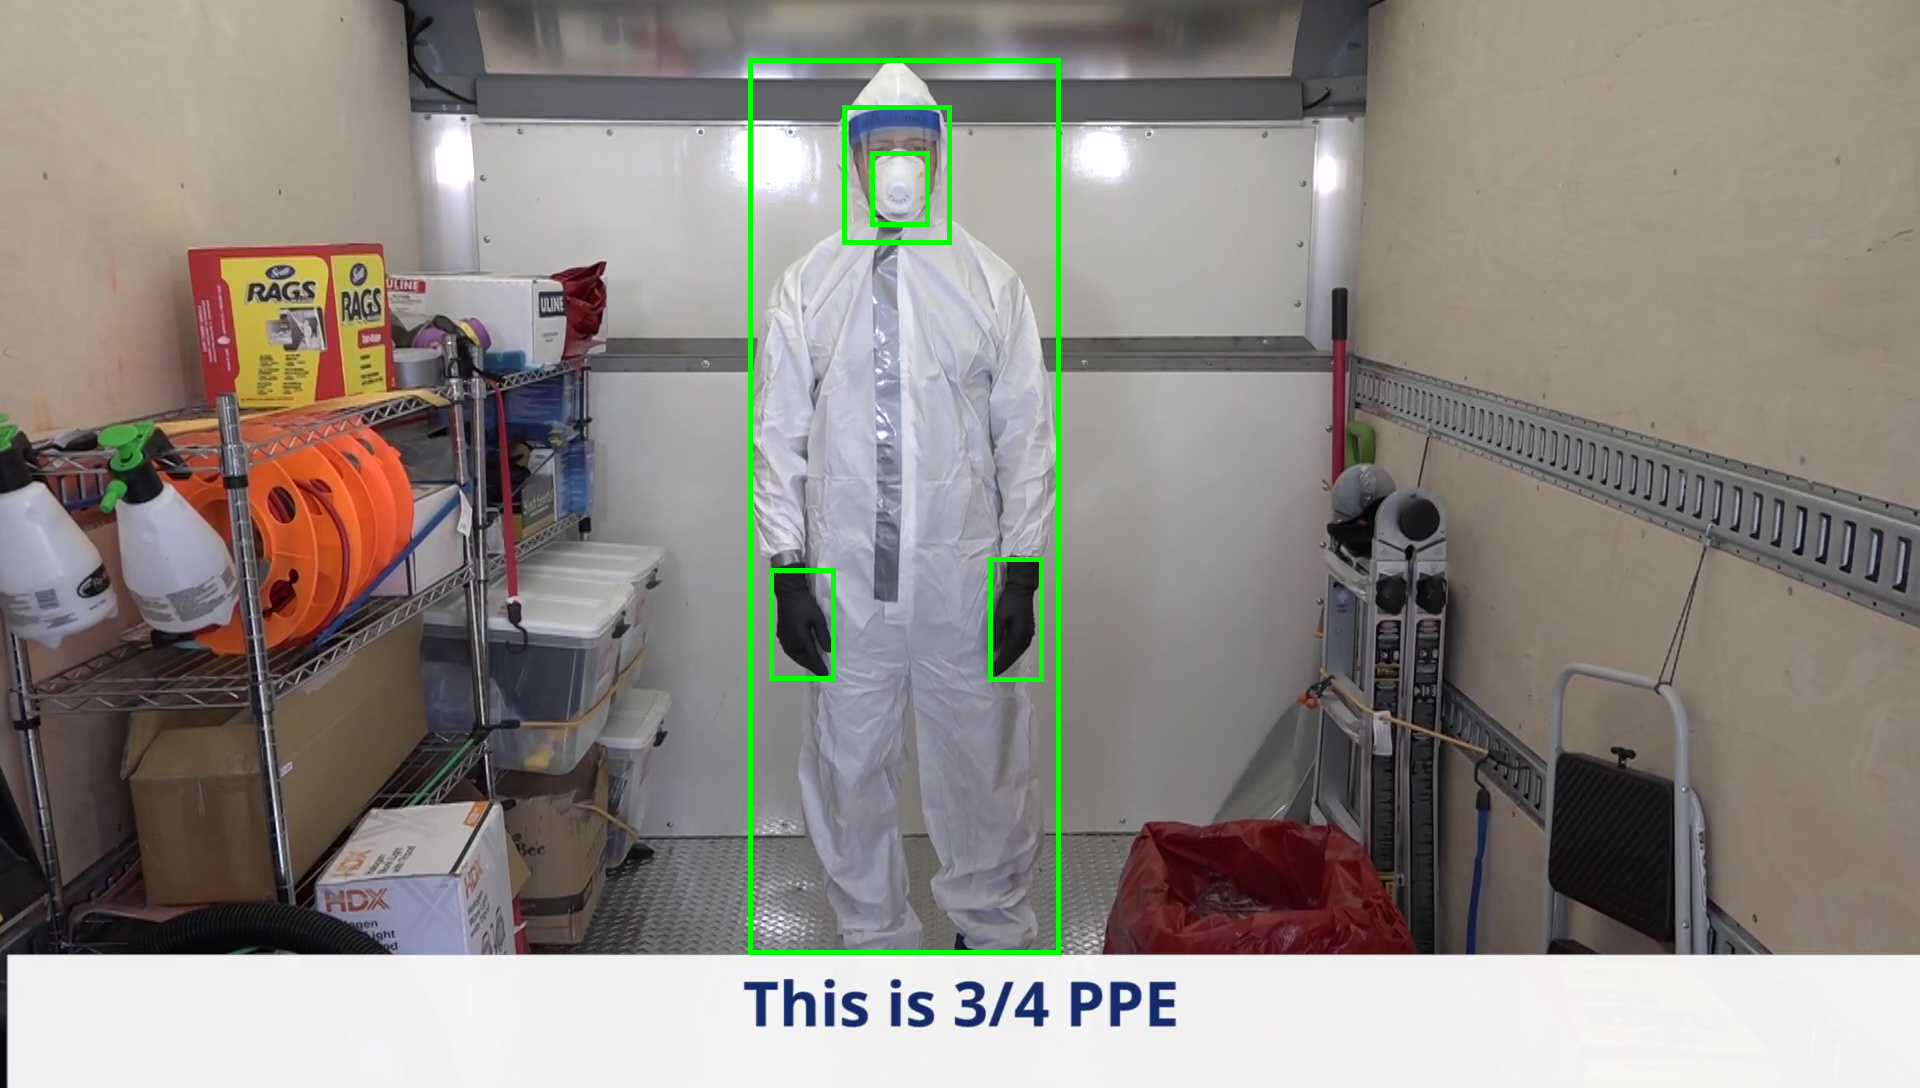

In [63]:
path = '/content/drive/MyDrive/Tensorflow/workspace/images/train'
data_df = train_df.copy()
data_df['file'] = path + '/' + data_df['filename']

ldf = data_df[data_df['file'] == data_df['file'][0]]

f=ldf.iloc[0].file
img = Image.open(f)
draw = ImageDraw.Draw(img)
xres, yres = img.size[0], img.size[1]

for i in range(len(ldf)):
    
    draw.rectangle([int(ldf.iloc[i]['xmin']),
                            int(ldf.iloc[i]['ymin']),
                            int(ldf.iloc[i]['xmax']),
                            int(ldf.iloc[i]['ymax'])], width=5, outline=(0,255,0))

img

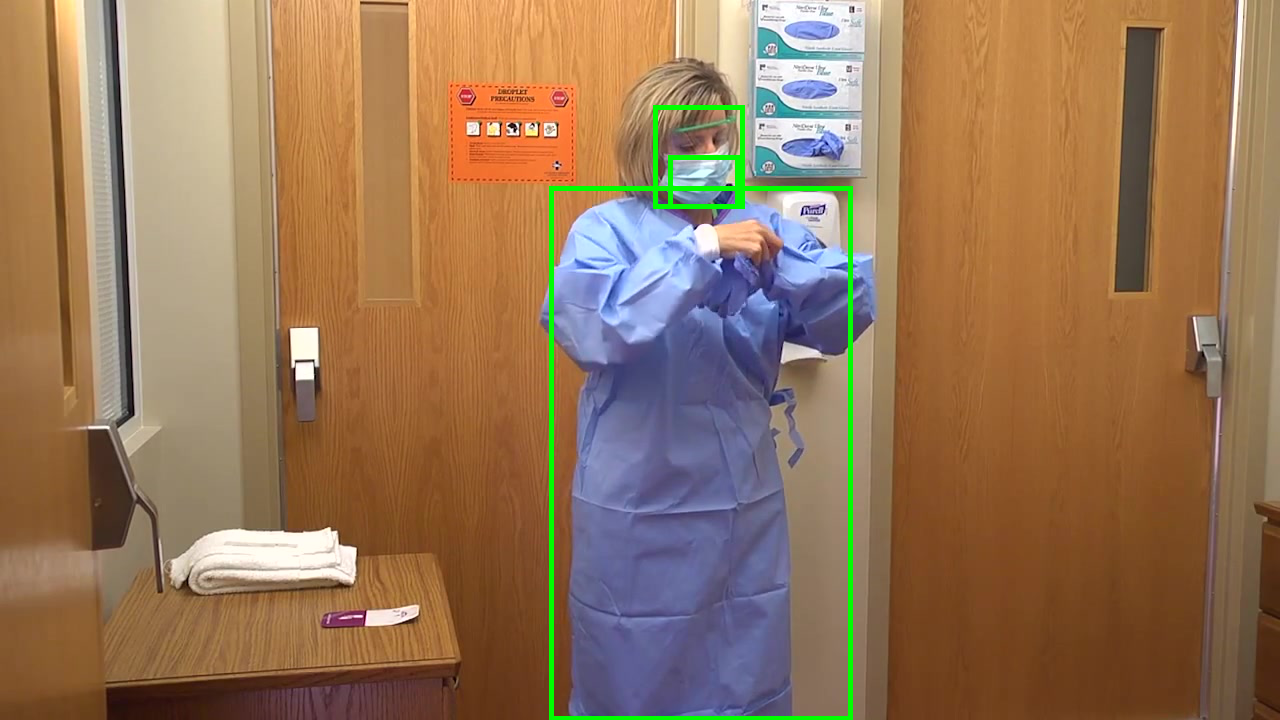

In [64]:
ldf = data_df[data_df['file'] == data_df['file'][10]]

f=ldf.iloc[0].file
img = Image.open(f)
draw = ImageDraw.Draw(img)
xres, yres = img.size[0], img.size[1]

for i in range(len(ldf)):
    
    draw.rectangle([int(ldf.iloc[i]['xmin']),
                            int(ldf.iloc[i]['ymin']),
                            int(ldf.iloc[i]['xmax']),
                            int(ldf.iloc[i]['ymax'])], width=5, outline=(0,255,0))

img

<a id="4"></a>
## <b>4 <span style='color:#B21010'>||</span> Define model name and url</b>

In [67]:
CUSTOM_MODEL_NAME = 'my_efficientdet_d1' 
PRETRAINED_MODEL_NAME = 'efficientdet_d1_coco17_tpu-32'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

<a id="5"></a>
## <b>5 <span style='color:#B21010'>||</span> Setup Paths</b>

In [68]:
tensor_path = '/content/drive/MyDrive/Tensorflow'

In [69]:
paths = {
    'WORKSPACE_PATH': os.path.join(tensor_path, 'workspace'),
    'SCRIPTS_PATH': os.path.join(tensor_path, 'scripts'),
    'APIMODEL_PATH': os.path.join(tensor_path,'models'),
    'ANNOTATION_PATH': os.path.join(tensor_path, 'workspace','annotations'),
    'IMAGE_PATH': os.path.join(tensor_path, 'workspace','images'),
    'MODEL_PATH': os.path.join(tensor_path, 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join(tensor_path, 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join(tensor_path, 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join(tensor_path, 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join(tensor_path, 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join(tensor_path, 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join(tensor_path,'protoc')
 }

In [70]:
files = {
    'PIPELINE_CONFIG':os.path.join(tensor_path, 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [71]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

<a id="6"></a>
## <b>6 <span style='color:#B21010'>||</span> Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD</b>

In [9]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [72]:
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd /content/drive/MyDrive/Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.6.1.3-2ubuntu5.2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/drive/MyDrive/Tensorflow/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     

In [73]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2023-05-03 21:26:04.753355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 21:26:06.738667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Running tests under Python 3.10.11: /usr/bin/py

In [74]:
import object_detection

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2023-05-03 01:06:44--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.117.128, 2607:f8b0:400e:c0a::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.253.117.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51839363 (49M) [application/x-tar]
Saving to: ‘efficientdet_d1_coco17_tpu-32.tar.gz’

efficientdet_d1_coc 100%[===================>]  49.44M   205MB/s    in 0.2s    

2023-05-03 01:06:45 (205 MB/s) - ‘efficientdet_d1_coco17_tpu-32.tar.gz’ saved [51839363/51839363]

efficientdet_d1_coco17_tpu-32/
efficientdet_d1_coco17_tpu-32/checkpoint/
efficientdet_d1_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d1_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d1_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d1_coco17_tpu-32/pipeline.config
efficientdet_d1_coco17_tpu-32/saved_model/
efficientdet

<a id="7"></a>
## <b>7 <span style='color:#B21010'>||</span> Copy Model Config to Training Folder</b>


In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

<a id="8"></a>
## <b>8 <span style='color:#B21010'>||</span> Update Config For Transfer Learning</b>



In [75]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     keep_aspect_ratio_resizer {
       min_dimension: 640
       max_dimension: 640
       pad_to_max_dimension: true
     }
   }
   feature_extractor {
     type: "ssd_efficientnet-b1_bifpn_keras"
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: SWISH
       batch_norm {
         decay: 0.9900000095367432
         scale: true
         epsilon: 0.0010000000474974513
       }
       force_use_bias: true
     }
     bifpn {
       min_level: 3
       max_level: 7
       num_iterations: 4
       num_filters: 88
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 1.0
       x_scale: 1.0
       height_scale: 1.0
       width_scale: 1.0
     }
   }
   matcher {
     argmax_matc

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = 5
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

In [15]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
config

{'model': ssd {
   num_classes: 5
   image_resizer {
     keep_aspect_ratio_resizer {
       min_dimension: 640
       max_dimension: 640
       pad_to_max_dimension: true
     }
   }
   feature_extractor {
     type: "ssd_efficientnet-b1_bifpn_keras"
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: SWISH
       batch_norm {
         decay: 0.9900000095367432
         scale: true
         epsilon: 0.0010000000474974513
       }
       force_use_bias: true
     }
     bifpn {
       min_level: 3
       max_level: 7
       num_iterations: 4
       num_filters: 88
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 1.0
       x_scale: 1.0
       height_scale: 1.0
       width_scale: 1.0
     }
   }
   matcher {
     argmax_match

<a id="9"></a>
## <b>9 <span style='color:#B21010'>||</span> Train the model </b>

In [16]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [17]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=30000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])
print(command)

python /content/drive/MyDrive/Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=/content/drive/MyDrive/Tensorflow/workspace/models/my_efficientdet_d1 --pipeline_config_path=/content/drive/MyDrive/Tensorflow/workspace/models/my_efficientdet_d1/pipeline.config --num_train_steps=30000


In [ ]:
!{command}

2023-05-03 01:25:02.779374: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2023-05-03 01:25:06.363962: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0503 01:25:06.394224 140543609333568 mir

In [17]:
!{command}

2023-05-03 09:45:49.844933: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2023-05-03 09:45:53.907950: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0503 09:45:53.949621 140506384598848 mir

<a id="10"></a>
## <b>10 <span style='color:#B21010'>||</span> Evaluate the model </b>


In [18]:
eval_command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])
!{eval_command}

2023-05-03 11:33:22.118725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
W0503 11:33:28.662117 140307883222848 model_lib_v2.py:1089] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0503 11:33:28.662461 140307883222848 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0503 11: